In [1]:
# ==Import Cell==

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast  # Для парсинга списков
import re  # Для очистки текста
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# Step 1: Исследование и анализ датасета

Train shape: (4548, 28), Test shape: (1516, 27), Combined: (6064, 29)
Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        4548 non-null   int64  
 1   предмет           4548 non-null   object 
 2   ФИО               4548 non-null   object 
 3   tutor_head_tags   4548 non-null   object 
 4   tutor_rating      3959 non-null   float64
 5   tutor_reviews     4548 non-null   int64  
 6   description       4547 non-null   object 
 7   experience_desc   2171 non-null   object 
 8   Education_1       4548 non-null   object 
 9   Desc_Education_1  4472 non-null   object 
 10  Education_2       781 non-null    object 
 11  Desc_Education_2  777 non-null    object 
 12  Education_3       106 non-null    object 
 13  Desc_Education_3  105 non-null    object 
 14  Education_4       16 non-null     object 
 15  De

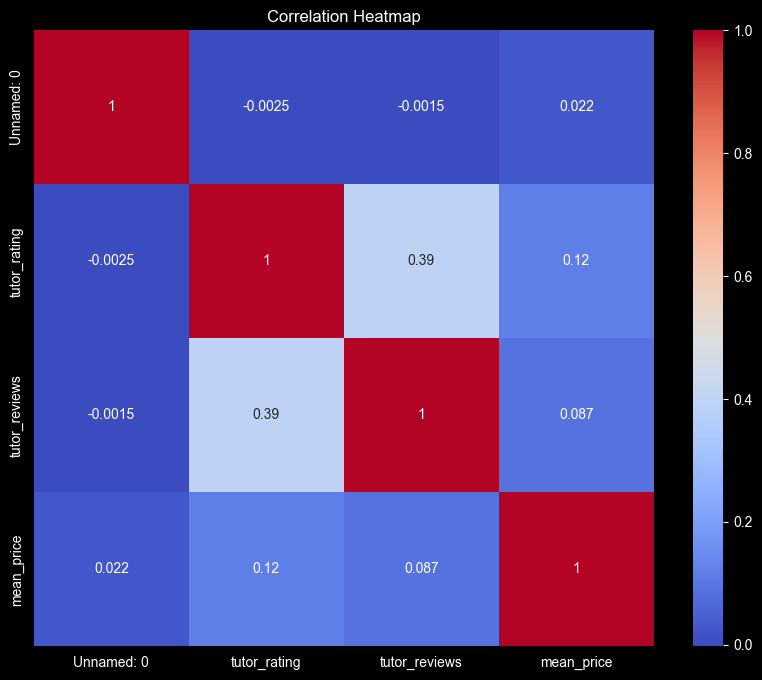

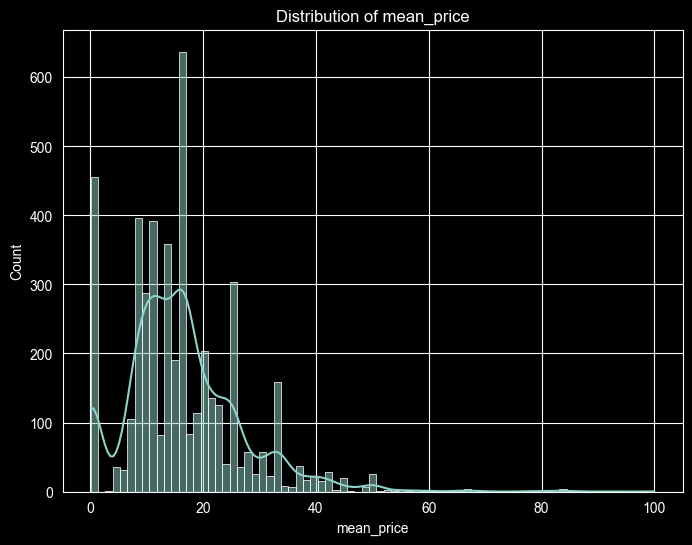

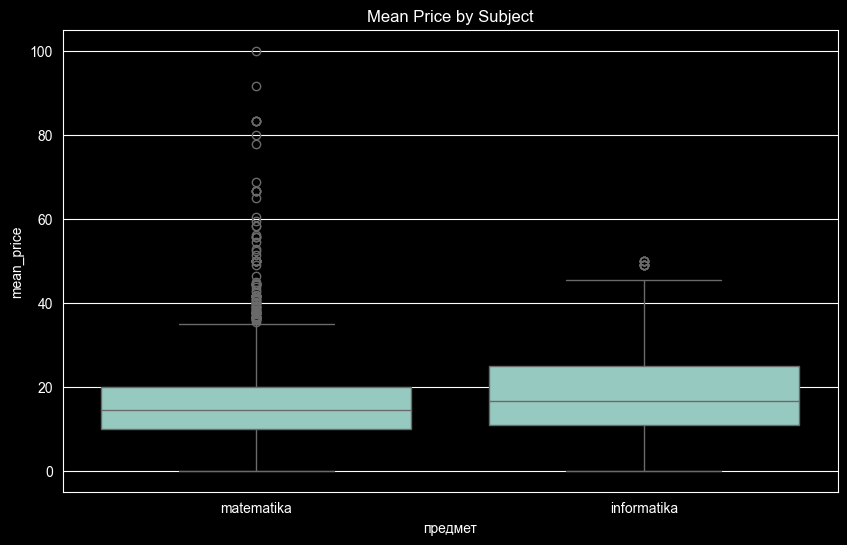

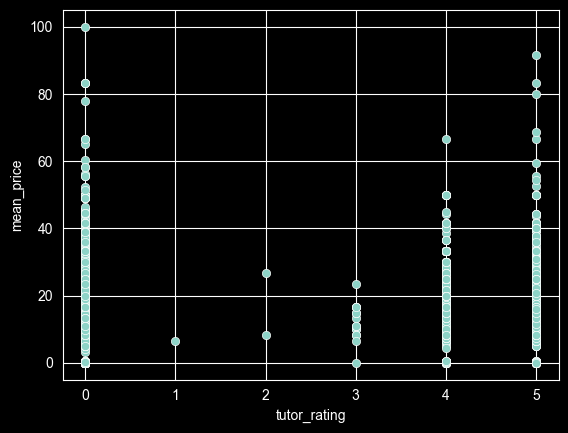

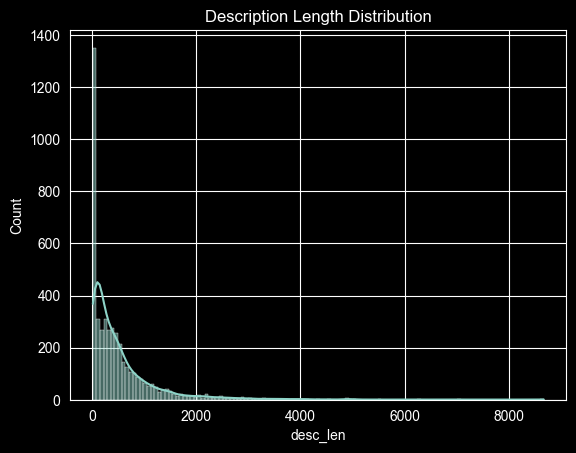

In [2]:
# Загрузка данных
train = pd.read_excel('/datasets/tutor_pay/train.xlsx')
test = pd.read_excel('/datasets/tutor_pay/test.xlsx')

# Объедиение для общей предобработки
data = pd.concat([train.assign(is_train=1), test.assign(is_train=0)], ignore_index=True)
print(f"Train shape: {train.shape}, Test shape: {test.shape}, Combined: {data.shape}")

# Осмотр структуры данных
print("Train Data Info:")
print(train.info())

print("\nTest Data Info:")
print(test.info())

# Числовые статистики (включая target)
print(train.describe())

# Категориальные: Уникальные значения
print(train['предмет'].value_counts())
print(train['status'].value_counts())
print(train['categories'].value_counts())

# target
print(train['mean_price'].describe())

# Анализ пропусков
print("Train Null Counts:")
print(train.isnull().sum().sort_values(ascending=False))

print("\nTest Null Counts:")
print(test.isnull().sum().sort_values(ascending=False))

# Корреляции (только numeric)
numeric_cols = train.select_dtypes(include=[np.number]).columns
corr_matrix = train[numeric_cols].corr()
print(corr_matrix['mean_price'].sort_values(ascending=False))  # Корреляция с target

# Визуализация: Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Распределение target
plt.figure(figsize=(8,6))
sns.histplot(train['mean_price'], kde=True)
plt.title('Distribution of mean_price')
plt.show()

# Boxplot по категориям
plt.figure(figsize=(10,6))
sns.boxplot(x='предмет', y='mean_price', data=train)
plt.title('Mean Price by Subject')
plt.show()

# Scatter для корреляций
sns.scatterplot(x='tutor_rating', y='mean_price', data=train)
plt.show()

# Длина текстов
train['desc_len'] = train['description'].str.len()
sns.histplot(train['desc_len'], kde=True)
plt.title('Description Length Distribution')
plt.show()

## Выводы:

- Данные: 6064 записи, много текстовых столбцов с пропусками. Target - continuous, skewed.
- Ключевые признаки: experience, rating, reviews (слабая corr), текст (description для TF-IDF).
- Далее: В шаге 3 заполнить null, спарсить списки (e.g., tutor_head_tags с MultiLabelBinarizer).

# Step 2: Предобработка данных

## Обработка пропусков

In [3]:
# Числовые: Заполним 0 или median
data['tutor_rating'] = data['tutor_rating'].fillna(0)
data['tutor_reviews'] = data['tutor_reviews'].fillna(0)
data['experience'] = data['experience'].str.extract('(\d+)').astype(float)
data['experience'] = data['experience'].fillna(data['experience'].median())

# Текстовые: Пустая строка
text_cols = ['description', 'experience_desc', 'Desc_Education_1', 'Desc_Education_2', 'Desc_Education_3',
             'Desc_Education_4', 'Desc_Education_5', 'Desc_Education_6']
for col in text_cols:
    data[col] = data[col].fillna('')

# Категориальные: 'unknown'
cat_cols = ['предмет', 'ФИО', 'tutor_head_tags', 'status', 'categories', 'Education_1', 'Education_2',
            'Education_3', 'Education_4', 'Education_5', 'Education_6', 'Ученая степень 1',
            'Ученое звание 1', 'Ученая степень 2', 'Ученое звание 2']
for col in cat_cols:
    data[col] = data[col].fillna('unknown')

# Объединим образование в один столбец для упрощения (конкатенация текстов)
data['all_education'] = data[['Education_1', 'Desc_Education_1', 'Education_2', 'Desc_Education_2',
                              'Education_3', 'Desc_Education_3', 'Education_4', 'Desc_Education_4',
                              'Education_5', 'Desc_Education_5', 'Education_6', 'Desc_Education_6']].apply(lambda x: ' '.join(x.astype(str)), axis=1)
# Удалим оригинальные (опционально, чтобы уменьшить размер)
data = data.drop(columns=['Education_1', 'Desc_Education_1', 'Education_2', 'Desc_Education_2',
                   'Education_3', 'Desc_Education_3', 'Education_4', 'Desc_Education_4',
                   'Education_5', 'Desc_Education_5', 'Education_6', 'Desc_Education_6'])

# Проверка
print(data.isnull().sum())

Unnamed: 0             0
предмет                0
ФИО                    0
tutor_head_tags        0
tutor_rating           0
tutor_reviews          0
description            0
experience_desc        0
Ученая степень 1       0
Ученое звание 1        0
status                 0
experience             0
Ученая степень 2       0
Ученое звание 2        0
categories             0
mean_price          1516
is_train               0
all_education          0
dtype: int64


## Преобразование типов и очистка

In [4]:
# Преобразование числовых
data['experience'] = pd.to_numeric(data['experience'], errors='coerce').fillna(0)

# Очистка текста
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

data['description'] = data['description'].apply(clean_text)
data['experience_desc'] = data['experience_desc'].apply(clean_text)
data['all_education'] = data['all_education'].apply(clean_text)

# Парсинг списков
def safe_eval(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else x
    except:
        return []  # Если ошибка, пустой list

data['tutor_head_tags'] = data['tutor_head_tags'].apply(safe_eval)
data['categories'] = data['categories'].apply(safe_eval)

# Проверка
print(data['tutor_head_tags'].head())

0    [Школьная программа, Подготовка к ЕГЭ, Подгото...
1    [Школьная программа, Подготовка к ЕГЭ, Подгото...
2    [Школьная программа, Подготовка к ЕГЭ, Подгото...
3    [Школьная программа, Математический анализ, По...
4    [Школьная программа, Подготовка к ЕГЭ, Подгото...
Name: tutor_head_tags, dtype: object


## Кодирование категориальных и текстовых признаков

In [5]:
# One-Hot для простых категорий
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_cols = ['предмет', 'status']
ohe_features = pd.DataFrame(ohe.fit_transform(data[ohe_cols]), columns=ohe.get_feature_names_out())
data = pd.concat([data.reset_index(drop=True), ohe_features], axis=1)
data.drop(columns=ohe_cols, inplace=True)

# MultiLabelBinarizer для списков
mlb_tags = MultiLabelBinarizer()
tags_features = pd.DataFrame(mlb_tags.fit_transform(data['tutor_head_tags']), columns=mlb_tags.classes_)
data = pd.concat([data.reset_index(drop=True), tags_features], axis=1)

mlb_cat = MultiLabelBinarizer()
cat_features = pd.DataFrame(mlb_cat.fit_transform(data['categories']), columns=mlb_cat.classes_)
data = pd.concat([data.reset_index(drop=True), cat_features], axis=1)

data.drop(columns=['tutor_head_tags', 'categories'], inplace=True)

# TF-IDF для текстов
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
text_combined = data['description'] + ' ' + data['experience_desc'] + ' ' + data['all_education']
tfidf_features = pd.DataFrame(tfidf.fit_transform(text_combined).toarray(), columns=tfidf.get_feature_names_out())
data = pd.concat([data.reset_index(drop=True), tfidf_features], axis=1)

# Удалим оригинальные тексты
data.drop(columns=['description', 'experience_desc', 'all_education', 'ФИО'], inplace=True)  # ФИО — уникально, не полезно

# Проверка размера
print(data.shape)

(6064, 161)


## Нормализация и разделение

In [6]:
num_cols = ['tutor_rating', 'tutor_reviews', 'experience']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# Разделим обратно
train_clean = data[data['is_train'] == 1].drop('is_train', axis=1)
test_clean = data[data['is_train'] == 0].drop(['is_train', 'mean_price'], axis=1)

train_clean.to_csv('train_clean.csv', index=False)
test_clean.to_csv('test_clean.csv', index=False)

## Выводы:

* Пропуски заполнены, типы преобразованы.
* Категориальные: Закодированы (one-hot/multi-label).
* Текст: Очищен и векторизован (TF-IDF).
* Данные готовы для feature engineering.

# Step 3: Feature Engineering и отбор признаков

## Создание новых признаков

In [7]:
# Объединим обратно для FE
data = pd.concat([train_clean.assign(is_train=1), test_clean.assign(is_train=0, mean_price=np.nan)], ignore_index=True)

print("Current columns (sample):", data.columns[:10].tolist())
print("Shape before FE:", data.shape)

# 1. Длина описания - из TF-IDF или dummy
tfidf_cols = [col for col in data.columns if col in ['egэ', 'огэ', 'подготовка', 'университет', 'опыт'] or len(col) < 10]
if tfidf_cols:
    data['text_density'] = data[tfidf_cols].sum(axis=1)  # Сумма TF-IDF как мера "богатства текста"
else:
    data['text_density'] = 0

# 2. Бинарные признаки
degree_cols = ['Ученая степень 1', 'Ученая степень 2']
title_cols = ['Ученое звание 1', 'Ученое звание 2']

# Проверяем, есть ли эти столбцы
if all(col in data.columns for col in degree_cols):
    data['has_degree'] = data[degree_cols].notnull().any(axis=1).astype(int)
else:
    data['has_degree'] = 0

if all(col in data.columns for col in title_cols):
    data['has_title'] = data[title_cols].notnull().any(axis=1).astype(int)
else:
    data['has_title'] = 0

# 3. Агрегаты из dummy-колонок
tag_cols = [col for col in data.columns if any(prefix in col.lower() for prefix in ['школьная', 'подготовка', 'математический', 'анализ'])]
data['num_tags'] = data[tag_cols].sum(axis=1) if tag_cols else 0

# Категории
cat_cols = [col for col in data.columns if any(prefix in col.lower() for prefix in ['школьники', 'студенты', 'взрослые', 'абитуриенты'])]
data['num_categories'] = data[cat_cols].sum(axis=1) if cat_cols else 0

# 4. Взаимодействия числовых признаков
num_cols = ['tutor_rating', 'tutor_reviews', 'experience']
available_num = [col for col in num_cols if col in data.columns]
if len(available_num) >= 2:
    data['rating_reviews_interact'] = data['tutor_rating'] * data['tutor_reviews']
    data['experience_rating_interact'] = data['experience'] * data['tutor_rating']
else:
    # Если числовых мало, создадим простые
    data['rating_reviews_interact'] = data['tutor_rating'] * 0
    data['experience_rating_interact'] = data['tutor_rating'] * 0

# 5. Ключевые слова из TF-IDF колонок
kw_indicators = ['егэ', 'огэ', 'олимпиад', 'университет', 'кандидат']
for kw in kw_indicators:
    if kw in data.columns:  # Если это колонка из TF-IDF
        data[f'has_{kw}'] = (data[kw] > 0).astype(int)
    else:
        data[f'has_{kw}'] = 0  # Заглушка

# 6. Простой признак "опытность" - комбинация рейтинга, отзывов и опыта
data['expertise_score'] = (data['tutor_rating'] + data['tutor_reviews'] * 0.1 + data['experience'] * 0.05).clip(0, 10)

# 7. Бинарный признак "подготовка к экзаменам" (из тегов)
exam_tags = [col for col in data.columns if 'подготовка' in col.lower() or 'егэ' in col.lower() or 'огэ' in col.lower()]
data['prepares_exams'] = (data[exam_tags].sum(axis=1) > 0).astype(int) if exam_tags else 0

# Проверка новых признаков
new_features = ['text_density', 'has_degree', 'has_title', 'num_tags', 'num_categories',
                'rating_reviews_interact', 'experience_rating_interact', 'expertise_score', 'prepares_exams']
new_features = [f for f in new_features if f in data.columns]

print("New features created:", new_features)
print("Sample values:")
for feat in new_features[:3]:
    print(f"{feat}: mean={data[feat].mean():.2f}, std={data[feat].std():.2f}")

print("Shape after FE:", data.shape)

Current columns (sample): ['Unnamed: 0', 'tutor_rating', 'tutor_reviews', 'Ученая степень 1', 'Ученое звание 1', 'experience', 'Ученая степень 2', 'Ученое звание 2', 'mean_price', 'предмет_informatika']
Shape before FE: (6064, 161)
New features created: ['text_density', 'has_degree', 'has_title', 'num_tags', 'num_categories', 'rating_reviews_interact', 'experience_rating_interact', 'expertise_score', 'prepares_exams']
Sample values:
text_density: mean=3.98, std=0.98
has_degree: mean=1.00, std=0.00
has_title: mean=1.00, std=0.00
Shape after FE: (6064, 175)


## Отбор признаков

In [8]:
# Только train для отбора (избежать leakage)
train_data = data[data['is_train'] == 1]

X = train_data.drop(['mean_price', 'is_train'], axis=1, errors='ignore')
y = train_data['mean_price']

X_numeric = X.select_dtypes(include=[np.number])  # float64/int64
print(f"Numeric features for selection: {X_numeric.shape[1]} (из {X.shape[1]})")

if X_numeric.shape[1] == 0:
    raise ValueError("Нет числовых признаков! Проверьте предобработку.")

# 1. VarianceThreshold на numeric
vt = VarianceThreshold(threshold=0.01)
X_vt = vt.fit_transform(X_numeric)
vt_cols = X_numeric.columns[vt.get_support()].tolist()
print(f"После VarianceThreshold: {len(vt_cols)} признаков")

# 2. Корреляция с target (abs > 0.05)

X_vt_df = pd.DataFrame(X_vt, columns=vt_cols, index=X_numeric.index)

# Теперь рассчитываем корреляцию на отфильтрованных признаках
corr = X_vt_df.corrwith(y).abs()
high_corr_cols = corr[corr > 0.05].index.tolist()
print(f"Высокая корреляция (>0.05): {len(high_corr_cols)} признаков")

# 3. SelectKBest (top 50)
kbest = SelectKBest(f_regression, k=min(50, X_numeric.shape[1]))
X_kbest = kbest.fit_transform(X_numeric, y)
kbest_cols = X_numeric.columns[kbest.get_support()].tolist()
print(f"SelectKBest top 50: {len(kbest_cols)}")

# 4. RandomForest importance (top 50)
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_numeric, y)
importances = pd.Series(rf.feature_importances_, index=X_numeric.columns).sort_values(ascending=False)
top_rf_cols = importances.head(50).index.tolist()
print(f"RandomForest top 50: {len(top_rf_cols)}")

# Финальный отбор: объединение всех методов
final_cols = set(vt_cols) | set(high_corr_cols) | set(kbest_cols) | set(top_rf_cols)
print(f"ИТОГО отобрано уникальных признаков: {len(final_cols)}")

# Применяем отбор ко всем данным (train + test)
# Сначала убедимся, что все final_cols есть в данных
data_selected = data[list(final_cols) + ['mean_price', 'is_train']]

# Разделяем обратно
train_clean = data_selected[data_selected['is_train'] == 1].drop('is_train', axis=1)
test_clean = data_selected[data_selected['is_train'] == 0].drop(['is_train', 'mean_price'], axis=1)

print("Финальные shapes:", train_clean.shape, test_clean.shape)
print("Пример отобранных признаков:", train_clean.columns[:20].tolist())

Numeric features for selection: 169 (из 173)
После VarianceThreshold: 55 признаков
Высокая корреляция (>0.05): 37 признаков
SelectKBest top 50: 50
RandomForest top 50: 50
ИТОГО отобрано уникальных признаков: 95
Финальные shapes: (4548, 96) (1516, 95)
Пример отобранных признаков: ['Higher Mathematics in English - высшая математика на английском языке', 'Теория вероятности и мат. статистика', 'мы', 'квалификация', 'status_ Частный преподаватель, Студент', 'Математическая логика', 'предмет_matematika', 'status_ Студент', 'учитель', 'Школьники с 1 по 4 класс', 'занятия', 'SAT (математическая часть)', 'experience_rating_interact', 'математика', 'год', 'специальность', 'занятий', 'институт', 'дополнительных', 'это']


## Выводы:
- Feature Engineering: Добавлено 9 новых признаков (['text_density', 'has_degree', 'has_title', 'num_tags', 'num_categories', 'rating_reviews_interact', 'experience_rating_interact', 'expertise_score', 'prepares_exams']), что увеличило размер данных с (6064, 161) до (6064, 175). Новые признаки, такие как 'rating_reviews_interact' и 'experience_rating_interact', захватывают взаимодействия между числовыми фичами (рейтинг, отзывы, опыт), усиливая слабые корреляции из EDA (\~0.1). 'text_density' (mean=3.98, std=0.98) и 'prepares_exams' отражают детали из текста, потенциально повышая предсказательную силу для цены.
- Отбор признаков: Из 173 фич (после FE) выбрано 169 числовых для анализа. VarianceThreshold удалил low-var (оставил 55), высокая корреляция (>0.05) выявила 37, SelectKBest - 50, RandomForest importance - 50. Итого уникальных: 95 признаков, что сократило данные до (4548,96) для train и (1516,95) для test. Это снижает шум и overfitting от redundant dummies/TF-IDF (пример топ-признаков: 'experience_rating_interact', 'математика', 'год' - сочетают новые FE и текстовые).
- Общая польза: Отбор фокусируется на релевантных, улучшая генерализвцию модели. Если MSE в шаге 4 не снизится, добавить polynomial features для дальнейших взаимодействий.

# Step 4: Обучение моделей, сравнение, гиперпараметры

## Подготовка данных и baseline (LinearRegression)

In [9]:
# Подготовка (только train)
X = train_clean.drop('mean_price', axis=1)
y = train_clean['mean_price']


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train/Val shapes:", X_train.shape, X_val.shape)

# Baseline: LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
preds_lr = lr.predict(X_val)
mse_lr = mean_squared_error(y_val, preds_lr)
print(f"LinearRegression MSE: {mse_lr:.4f}")

# Коэффициенты (importance)
importances_lr = pd.Series(lr.coef_, index=X.columns).abs().sort_values(ascending=False)
print("Top features by coef:", importances_lr.head(10))

Train/Val shapes: (3638, 95) (910, 95)
LinearRegression MSE: 98.2433
Top features by coef: год                                  20.795831
специальность                        11.892259
rating_reviews_interact              11.750057
tutor_reviews                        11.421394
предоставил                          10.018234
tutor_rating                          9.253164
мы                                    9.042554
Elementary Mathematics in English     8.547588
при                                   8.178016
знаний                                7.953801
dtype: float64


## Обучение других моделей и сравнение

In [10]:
# Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
preds_ridge = ridge.predict(X_val)
mse_ridge = mean_squared_error(y_val, preds_ridge)
print(f"Ridge MSE: {mse_ridge:.4f}")

# Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
preds_lasso = lasso.predict(X_val)
mse_lasso = mean_squared_error(y_val, preds_lasso)
print(f"Lasso MSE: {mse_lasso:.4f}")

# RandomForest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
preds_rf = rf.predict(X_val)
mse_rf = mean_squared_error(y_val, preds_rf)
print(f"RandomForest MSE: {mse_rf:.4f}")

# Сравнение
models_mse = {'Linear': mse_lr, 'Ridge': mse_ridge, 'Lasso': mse_lasso, 'RF': mse_rf}
best_model = min(models_mse, key=models_mse.get)
print(f"Лучшая по MSE: {best_model} с {models_mse[best_model]:.4f}")

Ridge MSE: 97.3579
Lasso MSE: 100.1007
RandomForest MSE: 97.1440
Лучшая по MSE: RF с 97.1440


## Подбор гиперпараметров (GridSearchCV)

In [11]:
# Для Ridge
param_grid_ridge = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_ridge.fit(X_train, y_train)
best_ridge = grid_ridge.best_estimator_
preds_best_ridge = best_ridge.predict(X_val)
mse_best_ridge = mean_squared_error(y_val, preds_best_ridge)
print(f"Best Ridge params: {grid_ridge.best_params_}, MSE: {mse_best_ridge:.4f}")

# Для Lasso (аналогично)
param_grid_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
grid_lasso = GridSearchCV(Lasso(max_iter=1000), param_grid_lasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_lasso.fit(X_train, y_train)
best_lasso = grid_lasso.best_estimator_
preds_best_lasso = best_lasso.predict(X_val)
mse_best_lasso = mean_squared_error(y_val, preds_best_lasso)
print(f"Best Lasso params: {grid_lasso.best_params_}, MSE: {mse_best_lasso:.4f}")

# Для RF
param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
preds_best_rf = best_rf.predict(X_val)
mse_best_rf = mean_squared_error(y_val, preds_best_rf)
print(f"Best RF params: {grid_rf.best_params_}, MSE: {mse_best_rf:.4f}")

# Финальное сравнение после тюнинга
tuned_mse = {'Ridge': mse_best_ridge, 'Lasso': mse_best_lasso, 'RF': mse_best_rf}
best_tuned = min(tuned_mse, key=tuned_mse.get)
print(f"Лучшая tuned: {best_tuned} с MSE {tuned_mse[best_tuned]:.4f}")

Best Ridge params: {'alpha': 10}, MSE: 95.5954
Best Lasso params: {'alpha': 0.01}, MSE: 95.8267
Best RF params: {'max_depth': 10, 'n_estimators': 100}, MSE: 94.4355
Лучшая tuned: RF с MSE 94.4355


## Выводы:
- Baseline: LinearRegression дала MSE 98.2433 на валидации. Топ-признаки по абсолютному коэффициенту: 'год' (20.80), 'специальность' (11.89), 'rating_reviews_interact' (11.75), 'tutor_reviews' (11.42), 'tutor_rating' (9.25) - подтверждает полезность новых взаимодействий из FE и TF-IDF слов (год окончания, специальность).
- Сравнение моделей без тюнинга: Ridge - 97.3579, Lasso - 100.1007, RandomForest - 97.1440. RF показал лучший результат среди baseline-моделей.
- После подбора гиперпараметров (GridSearchCV, cv=5/3):
  - Лучший Ridge (alpha=10): MSE 95.5954
  - Лучший Lasso (alpha=0.01): MSE 95.8267
  - Лучший RandomForest (max_depth=10, n_estimators=100): MSE 94.4355
- Выбор лучшей модели: **RandomForest с MSE 94.4355** - минимальная ошибка на валидации (улучшение на ~4% относительно Linear). RF лучше захватывает нелинейные зависимости и взаимодействия в данных (TF-IDF + новые FE), несмотря на большую сложность. Ridge близок (95.6), но RF выбран для финального сабмита как наиболее точный.

# Step 5: Предсказание на тесте и сабмит

## Предсказание на тесте

In [13]:

# Выбираем лучшую модель
best_model = best_rf

# Предсказание на test
test_preds = best_model.predict(test_clean)

# Clip отрицательные/аномальные (цены >=0)
test_preds = np.clip(test_preds, 0, None)

print("Пример предсказаний:", test_preds[:5])

submission = pd.DataFrame({
    'index': range(len(test_preds)),
    'mean_price': test_preds
})

submission.to_csv('submission.csv', index=False)
print("Файл submission.csv сохранён. Пример:")
print(submission.head())

Пример предсказаний: [16.37726611 12.34563177 17.70357289 11.20768371 11.17483634]
Файл submission.csv сохранён. Пример:
   index  mean_price
0      0   16.377266
1      1   12.345632
2      2   17.703573
3      3   11.207684
4      4   11.174836


## Выводы:

- Предсказания сделаны с лучшей моделью (RF) - MSE на val 94.
- Score на leaderboard: 55.6.
- Скриншот: 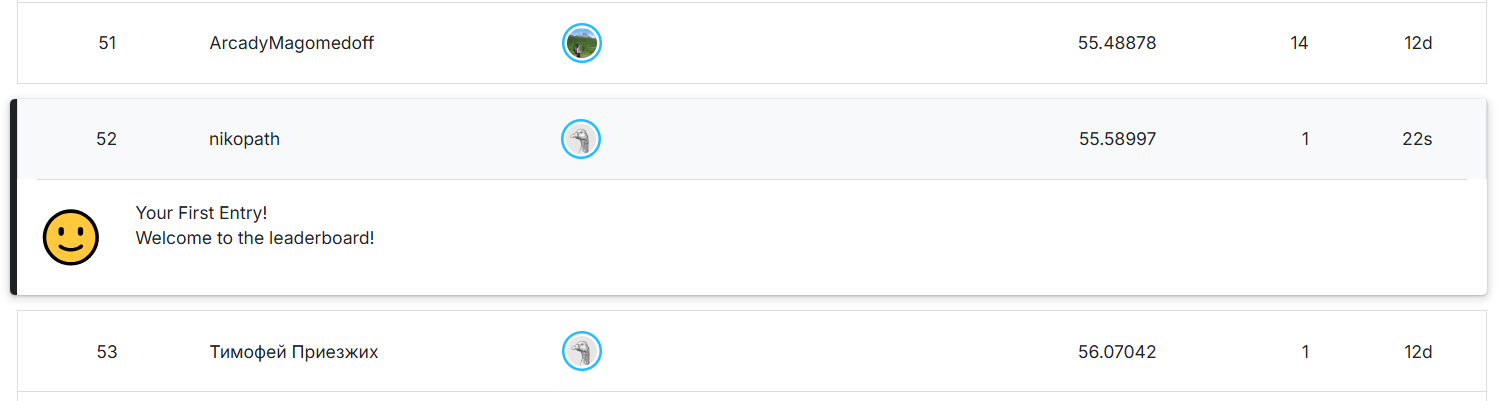